Import useful programs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging

#%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
om.__full_version__

'0.9.1.dev0+ed04b86'

In [3]:
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [4]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

In [5]:
# Import raw matrix into instance of om.Matrix() and plot it
# To use you own data, uncomment/adapt the line below instead
raw = om.Matrix(path="alfna_u233_aa.m")

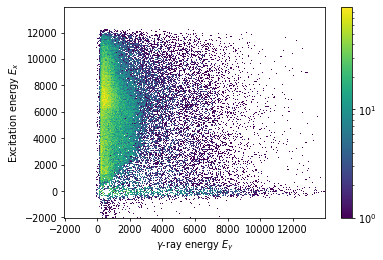

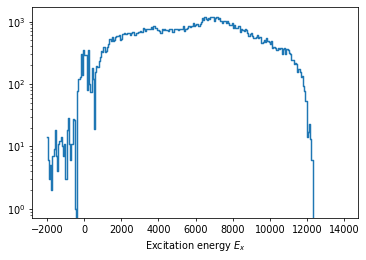

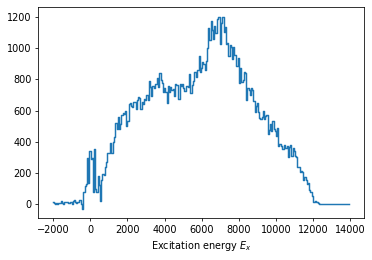

In [6]:
raw.plot();

# Plot projections
raw.plot_projection('Ex', scale='log', kind="step");
raw.plot_projection('Ex', kind="step");

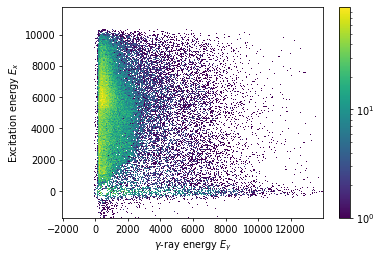

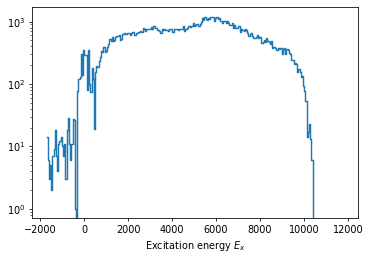

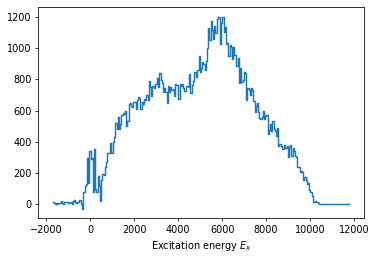

In [7]:
#New calibration to the theoretical fission barriers

raw.Ex = raw.Ex*0.8446 + 3.14e-16
raw.plot();

# Plot projections
raw.plot_projection('Ex', scale='log', kind="step");
raw.plot_projection('Ex', kind="step");

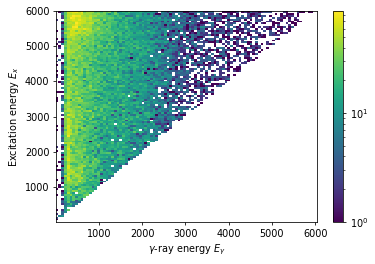

In [8]:
# Cut away counts above the diagonal
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.
# Note that the raw matrix we read in above has been cut already, so the difference here is not so large.
raw.cut_diagonal(E1=(0, 0), E2=(7500, 7500))
raw.cut('Ex', 0, 6000)


raw.cut('Eg', 0, 6000)
raw.plot();

From the GettingStarted OmPy manual: "Eventhough this experiment was performed with CACTUS, we will now give an example as if the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately."

So, I need to include the detector threshold for CACTUS

2020-03-25 17:57:45,293 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.
2020-03-25 17:57:45,936 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


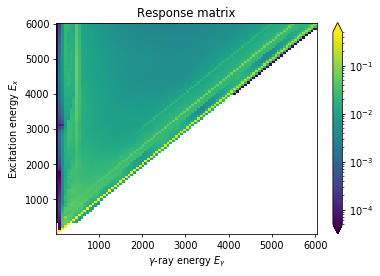

In [9]:
### GETTING RESPONSE MATRIX


logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "../OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
R_ompy_view.plot(title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");

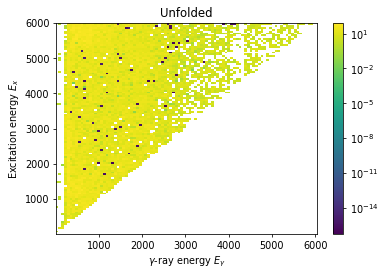

In [10]:
### UNFOLDING

# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=20)
#raw_positive.fill_negative(window_size=2.)
#raw_positive.remove_negative()

# With compton subtraction and all tweaks
unfolder = om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)
unfolded.plot();

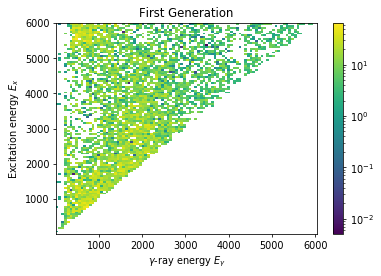

In [11]:
### Generate the first generation matrix

firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

In [12]:
### propagating statistical uncertainties


logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(10, regenerate=True)

2020-03-25 17:57:49,327 - ompy.ensemble - INFO - Start normalization with 3 cpus
2020-03-25 17:57:49,719 - ompy.ensemble - INFO - Generating 0
2020-03-25 17:57:49,746 - ompy.ensemble - INFO - Generating 1
2020-03-25 17:57:49,783 - ompy.ensemble - INFO - Generating 2


2020-03-25 17:57:51,566 - ompy.ensemble - INFO - Generating 3
2020-03-25 17:57:51,623 - ompy.ensemble - INFO - Generating 4
2020-03-25 17:57:51,714 - ompy.ensemble - INFO - Generating 5
2020-03-25 17:57:53,233 - ompy.ensemble - INFO - Generating 6
2020-03-25 17:57:53,478 - ompy.ensemble - INFO - Generating 7
2020-03-25 17:57:53,779 - ompy.ensemble - INFO - Generating 8
2020-03-25 17:57:54,948 - ompy.ensemble - INFO - Generating 9



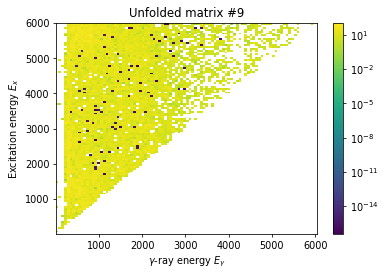

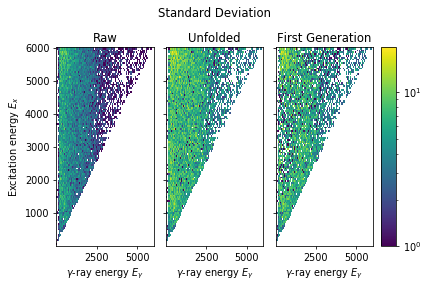

In [13]:
i_unfolded = 9
matrix = ensemble.get_unfolded(i_unfolded)
matrix.plot(title=f"Unfolded matrix #{i_unfolded}")

# Following commands plots all std. deviations
ensemble.plot();

Extract Nuclear level density and gamma strength function

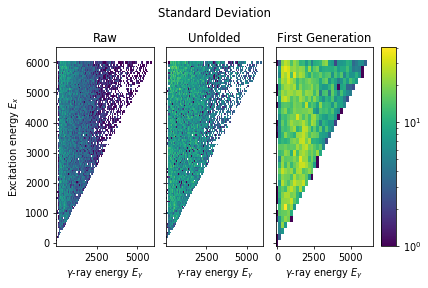

In [14]:
logger = om.introspection.get_logger('extractor', 'INFO')
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=1000, Ex_max=6000, Eg_min=1000, Eg_max = 6200, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace.
# Note: As always, be careful will mid-bin vs lower bin calibration.
#E_rebinned = ensemble.get_firstgen(0).Ex
#
E_rebinned = np.arange(0, 6500, 200.)
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

In [15]:
extractor.extract_from(ensemble, regenerate=True)

2020-03-25 17:57:59,910 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-03-25 17:57:59,911 - ompy.extractor - INFO - Minimizing
2020-03-25 17:58:00,751 - ompy.extractor - INFO - Optimization terminated successfully.
2020-03-25 17:58:00,753 - ompy.extractor - INFO -          Current function value: 1336.413266
2020-03-25 17:58:00,754 - ompy.extractor - INFO -          Iterations: 6
2020-03-25 17:58:00,754 - ompy.extractor - INFO -          Function evaluations: 4999
2020-03-25 17:58:00,957 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-03-25 17:58:00,958 - ompy.extractor - INFO - Minimizing
2020-03-25 17:58:01,953 - ompy.extractor - INFO - Optimization terminated successfully.
2020-03-25 17:58:01,954 - ompy.extractor - INFO -          Current function value: 1374.411936
2020-03-25 17:58:01,954 - ompy.extractor - INFO -          Iterations: 6
2020-03-25 17:58:01,955 - ompy.extractor - INFO -          Function evaluations: 4

2020-03-25 17:58:10,342 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-03-25 17:58:10,344 - ompy.extractor - INFO - Minimizing
2020-03-25 17:58:10,994 - ompy.extractor - INFO - Optimization terminated successfully.
2020-03-25 17:58:10,996 - ompy.extractor - INFO -          Current function value: 1336.464752
2020-03-25 17:58:10,997 - ompy.extractor - INFO -          Iterations: 5
2020-03-25 17:58:10,998 - ompy.extractor - INFO -          Function evaluations: 4191


array([   0., 1000., 1200., 1400., 1600., 1800., 2000., 2200., 2400.,
       2600., 2800., 3000., 3200., 3400., 3600., 3800., 4000., 4200.,
       4400., 4600., 4800., 5000., 5200., 5400., 5600., 5800., 6000.])

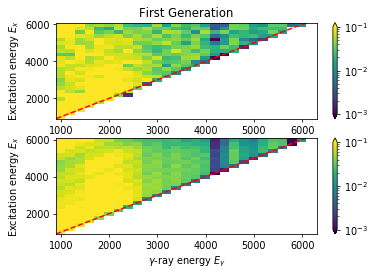

In [16]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)
fig, ax = plt.subplots(2,1)
om.normalize_rows(mat.values)
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1);
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1);
mat.Ex = np.insert(mat.Ex, 0, 0)
display(mat.Ex)

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g");
ax[1].plot(x, x, "r--", label="E_x = E_g");

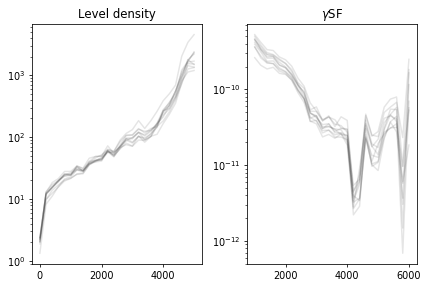

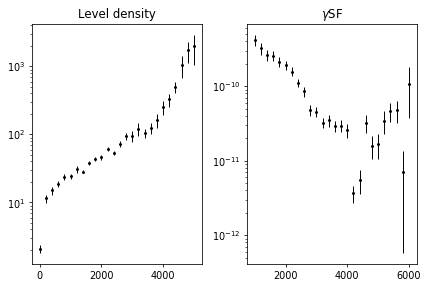

In [17]:
extractor.plot(plot_mean=False);
extractor.plot(plot_mean=True);

In [18]:
#display(nld.E)

In [19]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

# the "mean" nld at this stage; we'll use it later, but it's not a good estimate at this
# stage (see article)
nld_mean = extractor.ensemble_nld()

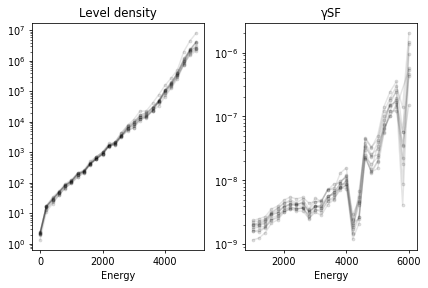

In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")

plot_transformed(alpha=0.0015);

In [21]:
normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
nldnorm = om.NormalizerNLD(nld=extractor.nld[0], discrete='discrete_levels_U233.txt', regenerate=True)

In [ ]:
norm_pars = om.NormalizationParameters(name='233U')
norm_pars.D0 = [4.6, 0.5]  # eV
norm_pars.Sn = [5.762, 0] # MeV
norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
norm_pars.spincutPars = {"mass":233, "NLDa":25.37, "Eshift":-0.51,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
norm_pars.Jtarget = 5/2 # A-1 nucleus

nldnorm.normalize(limit_low=[0, 0.5], limit_high=[1.5, 4.5], norm_pars=norm_pars)

2020-03-25 17:58:18,755 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2020-03-25 17:58:19,949 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬───────────────────┬─────────────────────┬─────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]             │ Eshift [MeV]        │
╞═══════════════════╪═══════════════════╪═════════════════════╪═════════════════════╡
│ 4.426649255662244 │ 1.161207839102082 │ 0.48083174137418705 │ -1.2901063154950008 │
└───────────────────┴───────────────────┴─────────────────────┴─────────────────────┘
2020-03-25 17:58:19,950 - ompy.normalizer_nld - INFO - Starting multinest


In [ ]:
nldnorm.plot();

In [ ]:
normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0], regenerate=True)

# to be use for gsf normalization
norm_pars.Gg = [27., 3.]  #meV

gsfnorm.norm_pars = norm_pars
gsfnorm.model_high.Efit = [4.5, 5.5]

In [ ]:
gsfnorm.normalize()
gsfnorm.plot();

In [ ]:


def f(x):
    return x

interact(f, x=10);
gsfnorm.plot_interactive()